<a href="https://colab.research.google.com/github/ckj18/ToBigs_workspace/blob/main/NN_Adv_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
# 디렉토리 위치 변경 
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


## Advanced NN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import warnings
warnings.filterwarnings(action='ignore')

# Data 

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

데이터 출처: https://github.com/zalandoresearch/fashion-mnist

# Load Data

In [283]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [284]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [285]:
train['label'].nunique()

10

In [286]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [287]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

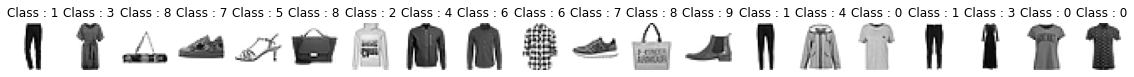

In [288]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [289]:
X_test = test.values

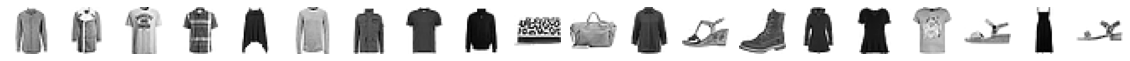

In [290]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

#### Train Test Split

In [291]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [292]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataSet(Dataset):

  def __init__(self, x_data, y_data = None, rows = 28, cols = 28):
    self.x_data = x_data.reshape(x_data.shape[0], 1, rows, cols)
    self.y_data = y_data

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, index):
    x = torch.FloatTensor(self.x_data[index])

    if self.y_data is None:
      return x
    else:
      y = torch.LongTensor(self.y_data.reshape(-1,1)[index])[0]
      return x, y
     

In [293]:
# Dataloader 설정

batch = 128

train_dataset = CustomDataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch, shuffle = True)

val_dataset = CustomDataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = batch, shuffle = True)

test_dataset = CustomDataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = batch, shuffle = False)

# Model - function

In [294]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [295]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=5, verbose=False, delta=0, path='./net_pretrained.pth'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: './net_pretrained.pth'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [296]:
# 모델 학습

def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(device)
    label = label.to(device)
    
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)

  return train_loss, train_accuracy

In [297]:
# 모델 평가
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(device)
      label = label.to(device)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

# Model - ResNet

In [347]:
class ResNet(nn.Module):
  def __init__(self, num_classes = 10):
    super(ResNet, self).__init__()
    self.in_channels = 32
    
    self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    self.layer1 = self.get_layer(32, 2, stride = 2)
    self.layer2 = self.get_layer(128, 2, stride = 2)
    self.layer3 = self.get_layer(256, 2, stride = 2)
    self.fc = nn.Linear(256, num_classes)

  def get_layer(self, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_channels, out_channels, stride))
      self.in_channels = out_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [348]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.shortcut = nn.Sequential()

    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False),
          nn.BatchNorm2d(out_channels))
      
  def forward(self, h):
    x = F.relu(self.bn1(self.conv1(h)))
    x = self.bn2(self.conv2(x))
    x += self.shortcut(h)
    x = F.relu(x)
    return x

In [355]:
# Model: ResNet, Optimizer: Adam, Scheduler: ReduceLROnPlateau, Criterion: CrossEntropyLoss 사용

model = ResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

# Evaluation

In [356]:
epochs = 100
patience = 7

result_list = []

# EarlyStopping 실행
early_stopping = EarlyStopping(patience = patience, verbose = True)


for epoch in range(1, epochs + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)

  scheduler.step(val_loss)
  early_stopping(val_loss, model)

  # patience 동안 val_loss가 감소하지 않으면 조기 종료
  if early_stopping.early_stop:
    print("Early stopping")
    break

  # val_loss 감소하면 model 저장
  model.load_state_dict(torch.load('./net_pretrained.pth'))

  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

Validation loss decreased (inf --> 0.387041).  Saving model ...
[EPOCH: 1], 	Train Loss: 0.6072, 	Train Accuracy: 77.48 %, 	Val Loss: 0.3870, 	Val Accuracy: 85.92 % 

Validation loss decreased (0.387041 --> 0.348674).  Saving model ...
[EPOCH: 2], 	Train Loss: 0.3507, 	Train Accuracy: 87.04 %, 	Val Loss: 0.3487, 	Val Accuracy: 87.49 % 

EarlyStopping counter: 1 out of 7
[EPOCH: 3], 	Train Loss: 0.3071, 	Train Accuracy: 88.72 %, 	Val Loss: 0.3641, 	Val Accuracy: 87.33 % 

EarlyStopping counter: 2 out of 7
[EPOCH: 4], 	Train Loss: 0.3116, 	Train Accuracy: 88.72 %, 	Val Loss: 0.3509, 	Val Accuracy: 87.10 % 

Validation loss decreased (0.348674 --> 0.300463).  Saving model ...
[EPOCH: 5], 	Train Loss: 0.3121, 	Train Accuracy: 88.66 %, 	Val Loss: 0.3005, 	Val Accuracy: 88.81 % 

EarlyStopping counter: 1 out of 7
[EPOCH: 6], 	Train Loss: 0.2883, 	Train Accuracy: 89.61 %, 	Val Loss: 0.3407, 	Val Accuracy: 87.22 % 

Validation loss decreased (0.300463 --> 0.300388).  Saving model ...
[EPOCH: 7

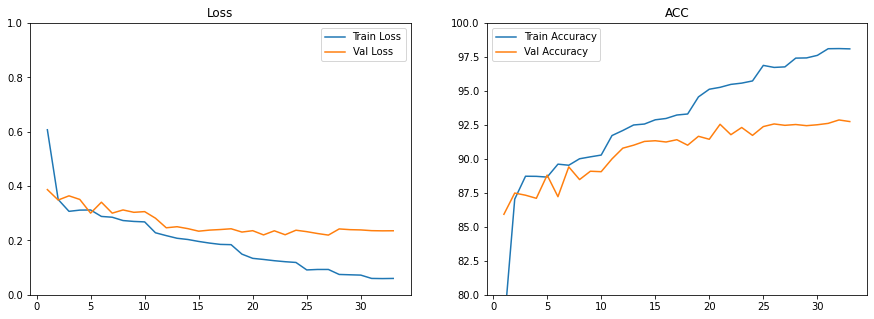

In [357]:
# Loss 및 Acc 변화 그래프
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()